## Helper functions & imports

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import statistics
import scipy.optimize
import random

def k_moment(data, k=1):
    """
        This function returns the estimate of the kth moment of the data set.
    """
    n=len(data)
    sum=np.sum(data**k)
    return (1/n)*sum

def res(params, f, bin_edges, hist, yerr):
    """

    Calculates the chi squared value of certain parameters for fit function s on histogram hist.

    Arguments:
            f       (function)                  The function that we want to test the parameters on
            x       (array-like)                Dataset of x values
            y       (array-like)                Dataset of corresponding y values
            yerr    (array-like)                Dataset containing the corresponding error in those y values
    Returns:
            result  (float)                     The chi squared value of parameters a & b on function f of the dataset.

    """
    result = 0
    N = np.sum(hist)
    cbins = (bin_edges[:-1]+bin_edges[1:])/2   # calculate centres of the bins
    prediction = f(cbins, params[0], params[1]) # use those centres as x values

    for i in range(0, len(hist)):
        result += ((hist[i] - prediction[i])**2/(yerr[i])**2)
    return result

def compare_fit(x, fit_y, method: str=""):
    # plots your fit function into the histograms
    # fit_y is your array of y values.
    # The "method" parameter is just to put it in the title of the plot
    # Returns n, the values of the histogram bins.

    fig,ax=plt.subplots(1, 4, figsize=(15,4), constrained_layout=True)
    for k,i in enumerate(bins):
        n = ax[k].hist(s, i,color='purple', density=True)
        ax[k].plot(x, fit_y, color='orange') # Plot the fit function
    fig.suptitle(f"Histograms of mixed data - {method}")
    plt.show()
    return n

bins = [5,10,50, 100] # Amount of bins used for the histograms. Given in the exercise.

# Our fit function that we use everywhere; a=lambda1, b=lambda2.
f = lambda x,a, b: 0.5*(a*np.exp(-a*x) + b*np.exp(-b*x))

## Generating data

In [21]:
#Generating the two random datasets of exponential distributions (lambda=10,lambda=50)
s1 = np.random.exponential((1/10),1000)
s2 = np.random.exponential((1/50),1000)
#mixing data sets
s = np.append(s1, s2)

## Method of moments

From applying the method of moments on this randomly generated exponential mixed dataset we obtain: lambda_1=10.46885314446113 lambda_2=43.76612645478553


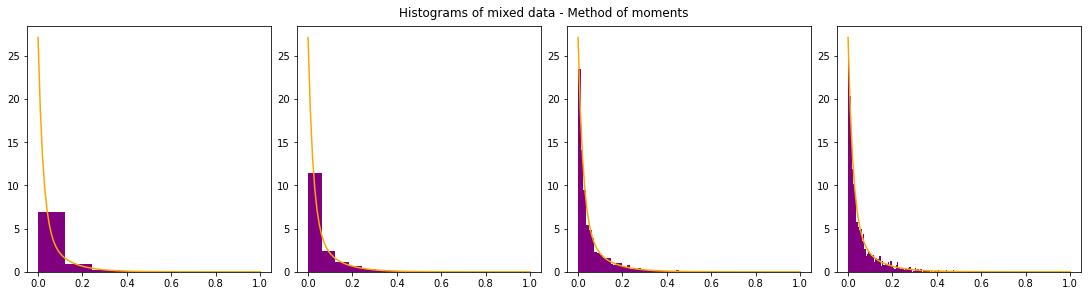

In [22]:
#We are trying to estimate two parameters so we only need 2 moments.
# print(s)
(m1,m2)= (k_moment(s,1),k_moment(s,2))
# print(m1)
# print(m2)
# print((m2/2 - m1**2))
# Using the formulas we derived:
lambda1=(m1+np.sqrt(0.5*m2-m1**2))**(-1)
lambda2=(m1-np.sqrt(0.5*m2-m1**2))**(-1)

print(rf"From applying the method of moments on this randomly generated exponential mixed dataset we obtain: lambda_1={lambda1} lambda_2={lambda2}")

x= np.linspace(0,1,100)

# Here we just wanna plot but the hist_values and bin_edges will be used later in the least squares method.
hist = compare_fit(x, f(x, lambda1, lambda2), "Method of moments")
hist_values = hist[0]
bin_edges = hist[1]

## Method of least squares

### Without statistical error

Least squares without uncertainty gives lambda1=9.836023299240974 & lambda2=50.70471499967257


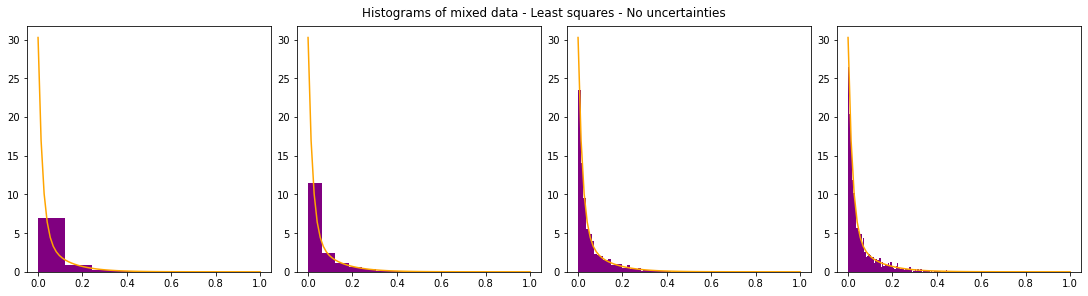

In [23]:
i_nonzero = hist[0] !=0 # You don't wanna take places into account where the histogram is 0
x = np.linspace(0,1, len(hist[0][i_nonzero]))

yerr = [1 for i in range(len(hist[0][i_nonzero]))]
result = scipy.optimize.least_squares(res, [10,50], args=(f,bin_edges, hist_values[i_nonzero], yerr), bounds=(1,100))
print(f"Least squares without uncertainty gives lambda1={result.x[0]} & lambda2={result.x[1]}")
dummyvar = compare_fit(x, f(x,result.x[0],result.x[1]), "Least squares - No uncertainties")

### With statistical error

Least squares with uncertainty gives lambda1=10.648942963388459 & lambda2=51.39324003180707


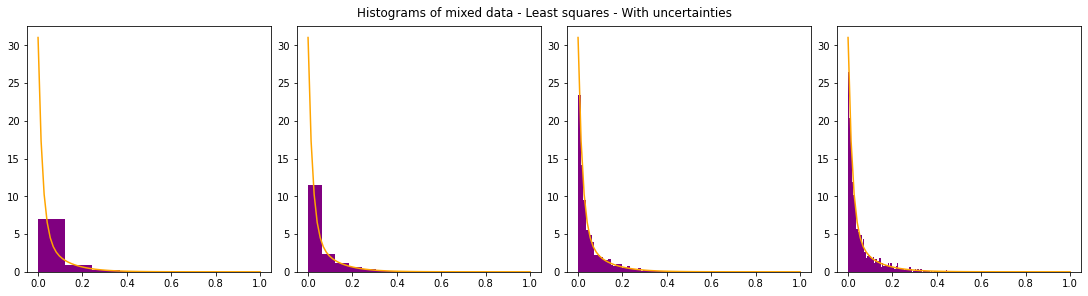

In [24]:
# Let's care about statistical uncertainties now.
yerr = np.sqrt(hist[0][i_nonzero]) # The formula for chisquared now is (O-E)^2/E but the E (expected value) is squared in the formula we wrote so here we compensate for that.
result = scipy.optimize.least_squares(res, [10,50], args=(f,bin_edges, hist_values[i_nonzero], yerr))
print(f"Least squares with uncertainty gives lambda1={result.x[0]} & lambda2={result.x[1]}")

dummyvar = compare_fit(x, f(x,result.x[0],result.x[1]), "Least squares - With uncertainties")

### With integration

In [ ]:
pass